# prepare the tables that can be used to annotate GWAS studies

this essentially adds the columns needed to the files

In [6]:
import pandas as pd
import numpy as np
import hicstraw 
from multiprocessing import Pool
import subprocess
from functools import partial
import glob
import os
import plotly.express as px
import math
import matplotlib.pyplot as plt
from matplotlib import colors
from pandarallel import pandarallel
import cooler
import cooltools
import pybedtools as pbed
pandarallel.initialize()
import scipy
from statsmodels.stats import multitest
import statsmodels.api as sm
import statsmodels.formula.api as smf
import plotly.io as pio
import seaborn as sns
import gzip
import io
import pickle
from functools import reduce

os.makedirs("/mnt/iusers01/jw01/mdefscs4/scratch/temp_pybedtools/", exist_ok = True)
pbed.helpers.set_tempdir("/mnt/iusers01/jw01/mdefscs4/scratch/temp_pybedtools/")
bed_genome_file = "/mnt/iusers01/jw01/mdefscs4/hg38.genome"

plt.rcParams['svg.fonttype'] = 'none'

base_dir = "/mnt/jw01-aruk-home01/projects/psa_functional_genomics/PsA_cleaned_analysis"

INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## load all the preprocessed data

In [ ]:
all_SNPs_CD4_all = pickle.load(open(f"{base_dir}/ATAC_allelic_imbalance/combined_p_vals_files/result_all_results_CD4_all.pkl", "rb"))
all_SNPs_CD8_all = pickle.load(open(f"{base_dir}/ATAC_allelic_imbalance/combined_p_vals_files/result_all_results_CD8_all.pkl", "rb"))
all_SNPs_all = pickle.load(open(f"{base_dir}/ATAC_allelic_imbalance/combined_p_vals_files/result_all_results.pkl", "rb"))

## add FDR correction column

In [3]:
def add_fdr(df):
    df["corrected_p_val_greater"] = multitest.multipletests(df["combined_p_val_greater"], method = "fdr_bh",alpha = 0.1)[1]
    df["corrected_p_val_less"] = multitest.multipletests(df["combined_p_val_less"], method = "fdr_bh",alpha = 0.1)[1]
for i in [all_SNPs_CD4_all,all_SNPs_CD8_all,all_SNPs_all]:
    add_fdr(i)

## add TF sites
these are JASPAR motifs and remap2022 peaks

In [4]:
def add_motifs(df):
    df_interesting = df[["CHROM", "POS"]].copy()

    # Add START and END columns
    df_interesting["START"] = df_interesting["POS"] - 1
    df_interesting["END"] = df_interesting["POS"] + 1

    # Create a BedTool object from the DataFrame
    bed_interesting = pbed.BedTool.from_dataframe(df_interesting[["CHROM", "START","END", "POS"]])

    # Load the other bed file as a BedTool object
    other_bed_file = pbed.BedTool("/mnt/jw01-aruk-home01/projects/psa_functional_genomics/NEW_references/TF_sites/ReMap/remap2022_nr_macs2_hg38_v1_0.bed.gz")

    # Intersect bed_interesting with the other bed file
    intersected_bed = bed_interesting.intersect(other_bed_file, wa=True, wb=True)

    # Convert the intersected BedTool object back to a DataFrame
    intersected_df = intersected_bed.to_dataframe(header = None, disable_auto_names = True)
    intersected_df.columns = "CHROM START END POS chr_ann start_ann end_ann annotation n_ann strand_ann center_s center_e color".split()
    # Apply your specific function to the intersected_df
    def get_protein_set(group):
        protein_set = set()
        for annotation in group['annotation']:
            protein = annotation.split(':')[0]
            protein_set.add(protein)
        return protein_set

    # Group the dataframe and apply the function to each group
    grouped = intersected_df.groupby(['CHROM', 'START', 'END', 'POS']).apply(get_protein_set)

    # Construct a new dataframe with the results
    intersected_df = pd.DataFrame(grouped, columns=['TF_remap']).reset_index()

    # Drop the START and END columns from the intersected_df
    intersected_df = intersected_df.drop(["START", "END"], axis=1)

    # Merge the result back with the original DataFrame
    merged_df = pd.merge(df, intersected_df, on=["CHROM", "POS"], how="left")
    return merged_df

pool = Pool(processes=3)
all_SNPs_CD4_all, all_SNPs_CD8_all, all_SNPs_all = pool.map(add_motifs, [all_SNPs_CD4_all,all_SNPs_CD8_all,all_SNPs_all])
pool.close()
pool.join()


In [ ]:
def add_motifs_jaspar(df):
    df_interesting = df[["CHROM", "POS"]].copy()

    # Add START and END columns
    df_interesting["START"] = df_interesting["POS"] - 50
    df_interesting["END"] = df_interesting["POS"] + 50

    # Create a BedTool object from the DataFrame
    bed_interesting = pbed.BedTool.from_dataframe(df_interesting[["CHROM", "START","END", "POS"]]).sort()

    # Load the other bed file as a BedTool object
    other_bed_file = pbed.BedTool("/mnt/jw01-aruk-home01/projects/psa_functional_genomics/NEW_references/TF_sites/jaspar2022/JASPAR2022_hg38_score400.bed.gz")

    # Intersect bed_interesting with the other bed file
    intersected_bed = bed_interesting.intersect(other_bed_file, wa=True, wb=True, sorted = True)

    # Convert the intersected BedTool object back to a DataFrame
    intersected_df = intersected_bed.to_dataframe(header = None, disable_auto_names = True)
    intersected_df.columns = "CHROM START END POS chr_ann start_ann end_ann annotation score strand_ann protein".split()
    # Apply your specific function to the intersected_df
    def get_protein_set(group):
        protein_set = set()
        for annotation in group['protein']:
            protein_set.add(annotation)
        return protein_set

    # Group the dataframe and apply the function to each group
    grouped = intersected_df.groupby(['CHROM', 'START', 'END', 'POS']).apply(get_protein_set)

    # Construct a new dataframe with the results
    intersected_df = pd.DataFrame(grouped, columns=['TF_JASPAR']).reset_index()

    # Drop the START and END columns from the intersected_df
    intersected_df = intersected_df.drop(["START", "END"], axis=1)

    # Merge the result back with the original DataFrame
    merged_df = pd.merge(df, intersected_df, on=["CHROM", "POS"], how="left")
    return merged_df

pool = Pool(processes=3)
all_SNPs_CD4_all, all_SNPs_CD8_all, all_SNPs_all = pool.map(add_motifs_jaspar, [all_SNPs_CD4_all,all_SNPs_CD8_all,all_SNPs_all])
pool.close()
pool.join()


## add eQTLs
using eQTLgen dataset

In [9]:
# load eQTLgen information
file_eqtlgen = "/mnt/jw01-aruk-home01/projects/psa_functional_genomics/NEW_references/eQTL/eQTLgen/2019-12-11-cis-eQTLsFDR0.05-ProbeLevel-CohortInfoRemoved-BonferroniAdded.txt.gz"
eqtlgen_database = pd.read_csv(file_eqtlgen,sep="\t")

In [10]:
eqtlgen_database["Pvalue"] = -np.log10(eqtlgen_database["Pvalue"])
eqtlgen_database["val"] = eqtlgen_database["GeneSymbol"].astype(str) + ": " + eqtlgen_database["Pvalue"].round(1).astype(str)
eqtlgen_database = eqtlgen_database.sort_values(by="Pvalue",ascending=False)

In [19]:
eqtlgen_genes = eqtlgen_database[eqtlgen_database["SNP"].isin(all_SNPs_all["ID"].unique())].groupby("SNP").agg({"Gene":list, "GeneSymbol": list, "val":list})
eqtlgen_genes.columns = "eQTLgen_gene eQTLgen_symbol eQTLgen_pval".split()
all_SNPs_all = all_SNPs_all.merge(eqtlgen_genes.reset_index(), left_on = "ID", right_on = "SNP", how = "left").drop("SNP", axis = 1)

eqtlgen_genes = eqtlgen_database[eqtlgen_database["SNP"].isin(all_SNPs_CD4_all["ID"].unique())].groupby("SNP").agg({"Gene":list, "GeneSymbol": list, "val":list})
eqtlgen_genes.columns = "eQTLgen_gene eQTLgen_symbol eQTLgen_pval".split()
all_SNPs_CD4_all = all_SNPs_CD4_all.merge(eqtlgen_genes.reset_index(), left_on = "ID", right_on = "SNP", how = "left").drop("SNP", axis = 1)

eqtlgen_genes = eqtlgen_database[eqtlgen_database["SNP"].isin(all_SNPs_CD8_all["ID"].unique())].groupby("SNP").agg({"Gene":list, "GeneSymbol": list, "val":list})
eqtlgen_genes.columns = "eQTLgen_gene eQTLgen_symbol eQTLgen_pval".split()
all_SNPs_CD8_all = all_SNPs_CD8_all.merge(eqtlgen_genes.reset_index(), left_on = "ID", right_on = "SNP", how = "left").drop("SNP", axis = 1)

## add if allele specific loop

In [4]:
output_dataframe_CD8 = pd.read_csv(f"{base_dir}/HiC_allelic_imbalance/output_dataframe_CD8.csv")
output_dataframe_CD4 = pd.read_csv(f"{base_dir}/HiC_allelic_imbalance/output_dataframe_CD4.csv")

In [5]:
df = all_SNPs_all.copy()
# df = df.drop(df[df["ID"] == "."].index)

In [6]:
def add_loop(df):
    grouped_CD4 = output_dataframe_CD4.groupby('rsID').agg({'corrected_Pval_greater': 'min', 'corrected_Pval_less': 'min'}).reset_index()
    grouped_CD8 = output_dataframe_CD8.groupby('rsID').agg({'corrected_Pval_greater': 'min', 'corrected_Pval_less': 'min'}).reset_index()

    # Merge the two dataframes based on the "ID" column in all_SNPs_all and the "rsID" column in grouped_CD4
    merged_df = df.merge(grouped_CD4[["rsID",'corrected_Pval_greater', 'corrected_Pval_less']], left_on='ID', right_on='rsID', how='left')

    # Create a new column 'lowest_corrected_Pval' which contains the lowest value between 'corrected_Pval_greater' and 'corrected_Pval_less' columns
    merged_df['CD4_lowest_allele_specific'] = merged_df[['corrected_Pval_greater', 'corrected_Pval_less']].min(axis=1)

    # Drop the unnecessary columns from the merged dataframe and store the result in all_SNPs_all
    df = merged_df.drop(columns=['rsID', 'corrected_Pval_greater', 'corrected_Pval_less'])

    # Merge the two dataframes based on the "ID" column in all_SNPs_all and the "rsID" column in grouped_CD4
    merged_df = df.merge(grouped_CD8[["rsID",'corrected_Pval_greater', 'corrected_Pval_less']], left_on='ID', right_on='rsID', how='left')

    # Create a new column 'lowest_corrected_Pval' which contains the lowest value between 'corrected_Pval_greater' and 'corrected_Pval_less' columns
    merged_df['CD8_lowest_allele_specific'] = merged_df[['corrected_Pval_greater', 'corrected_Pval_less']].min(axis=1)

    # Drop the unnecessary columns from the merged dataframe and store the result in all_SNPs_all
    df = merged_df.drop(columns=['rsID', 'corrected_Pval_greater', 'corrected_Pval_less'])
    return df

In [7]:
pool = Pool(processes=3)
all_SNPs_CD4_all, all_SNPs_CD8_all, all_SNPs_all = pool.map(add_loop, [all_SNPs_CD4_all,all_SNPs_CD8_all,all_SNPs_all])
pool.close()
pool.join()

## add ATAC_corr_scores
this only works because we have precomputed all the correlations between ATAC peak and Hi-C. if you don't have this don't run the next cells

In [ ]:
file_path = '/mnt/jw01-aruk-home01/projects/psa_functional_genomics/PsA_output_hic_plots/all_ATAC.txt'

# Read the file content
with open(file_path, 'r') as f:
    file_content = f.read()

# Extract the desired information using regex
pattern = r'chr(\d+)-(\d+)-(\d+)_([\d.]+).html'
matches = re.findall(pattern, file_content)

# Create a pandas DataFrame with the extracted information
atac_scores = pd.DataFrame(matches, columns=['chr', 'start', 'end', 'last_number'])

# Convert columns to appropriate data types
atac_scores['chr'] = "chr" + atac_scores['chr']
atac_scores['start'] = atac_scores['start'].astype(int)
atac_scores['end'] = atac_scores['end'].astype(int)
atac_scores['last_number'] = atac_scores['last_number'].astype(float)


In [ ]:
peaks_pbed = pbed.BedTool.from_dataframe(atac_scores)

In [ ]:
snps_anno_pbed = pbed.BedTool.from_dataframe(all_SNPs_all[["CHROM","POS","POS","ID"]])
res_anno_peaks = snps_anno_pbed.sort().closest(peaks_pbed.sort(), d = True).to_dataframe(header = None, disable_auto_names = True)
res_anno_peaks = res_anno_peaks[res_anno_peaks[8] < 500]
all_SNPs_all = all_SNPs_all.merge(res_anno_peaks[[0,1,3,7]], left_on = ["CHROM","POS","ID"], right_on = [0,1,3], how = "left",)
all_SNPs_all = all_SNPs_all.rename(columns = {7:"ATAC_hic_corr_score"})
all_SNPs_all = all_SNPs_all.drop([0,1,3], axis = 1)

In [ ]:
snps_anno_pbed = pbed.BedTool.from_dataframe(all_SNPs_CD4_all[["CHROM","POS","POS","ID"]])
res_anno_peaks = snps_anno_pbed.sort().closest(peaks_pbed.sort(), d = True).to_dataframe(header = None, disable_auto_names = True)
res_anno_peaks = res_anno_peaks[res_anno_peaks[8] < 500]
all_SNPs_CD4_all = all_SNPs_CD4_all.merge(res_anno_peaks[[0,1,3,7]], left_on = ["CHROM","POS","ID"], right_on = [0,1,3], how = "left",)
all_SNPs_CD4_all = all_SNPs_CD4_all.rename(columns = {7:"ATAC_hic_corr_score"})
all_SNPs_CD4_all = all_SNPs_CD4_all.drop([0,1,3], axis = 1)

In [ ]:
snps_anno_pbed = pbed.BedTool.from_dataframe(all_SNPs_CD8_all[["CHROM","POS","POS","ID"]])
res_anno_peaks = snps_anno_pbed.sort().closest(peaks_pbed.sort(), d = True).to_dataframe(header = None, disable_auto_names = True)
res_anno_peaks = res_anno_peaks[res_anno_peaks[8] < 500]
all_SNPs_CD8_all = all_SNPs_CD8_all.merge(res_anno_peaks[[0,1,3,7]], left_on = ["CHROM","POS","ID"], right_on = [0,1,3], how = "left",)
all_SNPs_CD8_all = all_SNPs_CD8_all.rename(columns = {7:"ATAC_hic_corr_score"})
all_SNPs_CD8_all = all_SNPs_CD8_all.drop([0,1,3], axis = 1)

## add EPIMAP links

In [4]:
epimap_links_folder = "/mnt/jw01-aruk-home01/projects/functional_genomics/references/epimap/epimap_broadinstitute_updated/links/links_corr_only/"
epimap_links_files = os.listdir(epimap_links_folder)
sample_metadata = "/mnt/jw01-aruk-home01/projects/functional_genomics/references/epimap/epimap_broadinstitute_updated/metadata/main_metadata_table.tsv"
metadata_df = pd.read_csv(sample_metadata, sep="\t")[["id","GROUP","ct","SECONDARY","infoline"]]
gtf_annotation_df = pd.read_pickle("/mnt/jw01-aruk-home01/projects/psa_functional_genomics/Quant-seq_tests/STAR_index/gencode_gtf.pickle")
gtf_transcripts = gtf_annotation_df[(gtf_annotation_df["feature"] == "transcript") & (gtf_annotation_df["transcript_type"] == "protein_coding")].dropna(axis=1, how='all')
gtf_transcripts["gene_id"] = gtf_transcripts["gene_id"].str.split(".").str[0]
gtf_transcripts["transcript_id"] = gtf_transcripts["transcript_id"].str.split(".").str[0]
gtf_transcripts["TSS_start"] = gtf_transcripts.apply(lambda x: int(x["start"]) if x["strand"] == "+" else int(x["end"]) ,axis = 1)
gene_mapper = dict(zip(gtf_transcripts['gene_id'], gtf_transcripts['gene_name']))

In [19]:
def annotate_epimap_links(snps_df):
    """Make sure it's hg19
    file has to be in following format:
    chr start end name score loci snp"""
    def single_epimap_links(df,epimap_file):
        cur_epimap = epimap_links_folder + epimap_file
        cur_epimap_pbed = pbed.BedTool(cur_epimap)
        df_pbed = pbed.BedTool.from_dataframe(df)
        intersect_result = df_pbed.intersect(cur_epimap_pbed, wa=True, wb=True)
        if intersect_result.count() == 0:
            return None
        else:
            res = intersect_result.to_dataframe(header=None,disable_auto_names=True)
            res["cell_type"] = epimap_file.split("_")[0]
            return res
    def intersect_with_epimap_links(df):
        results_list = []
        for epimap_file in epimap_links_files:
            res = single_epimap_links(df, epimap_file)
            if res is not None:
                results_list.append(res)
        if len(results_list) > 0:
            return pd.concat(results_list)
        else:
            return None
    
    snps_df = intersect_with_epimap_links(snps_df)
    snps_df.columns = "chr start end snp enh_chr enh_start enh_end gene_id link_score enh_type cell_type".split()
    
    snps_df = snps_df.merge(gtf_transcripts[["gene_id","gene_name","seqname","TSS_start"]].drop_duplicates("gene_id"), left_on = "gene_id", right_on = "gene_id", how ="left")
    
    snps_df = snps_df.merge(metadata_df, left_on = "cell_type", right_on = "id", how ="left")

    return snps_df

def retrieve_genes(snps_df, links_annotated_snps_df):
    def get_genes(df, group):
        if (len(df[(df["GROUP"] == group)]) > 0):
            return set(df.loc[(df["GROUP"] == group),"gene_name"].tolist())
        elif group == "ALL":
            return set(df.loc[:,"gene_name"].tolist())
        else:
            return False
    hsc_result = links_annotated_snps_df.groupby("snp").apply(get_genes, group = "HSC & B-cell")
    Tcell_result = links_annotated_snps_df.groupby("snp").apply(get_genes, group = "Blood & T-cell")
    all_result = links_annotated_snps_df.groupby("snp").apply(get_genes, group = "ALL")
    hsc_result.name = "hsc_genes"
    Tcell_result.name = "tcell_genes"
    all_result.name = "all_genes"
    snps_df = snps_df.merge(hsc_result, left_on = "snp", right_index = True, how = "outer")
    snps_df = snps_df.merge(Tcell_result, left_on = "snp", right_index = True, how = "outer")
    snps_df = snps_df.merge(all_result, left_on = "snp", right_index = True, how = "outer")
    return snps_df

In [31]:
def add_epimap(insnpdf):
    tmp = insnpdf[["CHROM","POS", "ID"]].copy()
    tmp = tmp[tmp["ID"] != "."]
    tmp["END"] = tmp["POS"] + 1
    pbed_snps = pbed.BedTool.from_dataframe(tmp[["CHROM","POS", "END", "ID"]])
    subprocess.run(["liftover", pbed_snps.fn, "hg38ToHg19.over.chain.gz", pbed_snps.fn + "_hg19.bed", "out"])
    hg19_snps = pd.read_csv(pbed_snps.fn + "_hg19.bed", sep = "\t", header = None)
    hg19_snps.columns = "chr start end snp".split()
    hg19_snps_links = annotate_epimap_links(hg19_snps)
    hg19_snps_links_annotated = retrieve_genes(hg19_snps,hg19_snps_links)
    insnpdf = insnpdf.merge(hg19_snps_links_annotated[["snp", "hsc_genes", "tcell_genes", "all_genes"]].drop_duplicates("snp"), left_on = "ID", right_on = "snp", how = "left")
    return insnpdf

In [32]:
pool = Pool(processes=3)
all_SNPs_CD4_all, all_SNPs_CD8_all, all_SNPs_all = pool.map(add_epimap, [all_SNPs_CD4_all,all_SNPs_CD8_all,all_SNPs_all])
pool.close()
pool.join()

Reading liftover chains
Mapping coordinates
Reading liftover chains
Mapping coordinates
Reading liftover chains
Mapping coordinates


In [ ]:
o = f"{base_dir}/ATAC_allelic_imbalance/combined_p_vals_files/"

all_SNPs_CD4_all.to_csv(o + "all_SNPs_CD4_all.csv") 
all_SNPs_CD8_all.to_csv(o + "all_SNPs_CD8_all.csv") 
all_SNPs_all.to_csv(o + "all_SNPs_all.csv")

all_SNPs_CD4_all.to_pickle(o + "all_SNPs_CD4_all.pkl")
all_SNPs_CD8_all.to_pickle(o + "all_SNPs_CD8_all.pkl")
all_SNPs_all.to_pickle(o + "all_SNPs_all.pkl")


In [8]:
o = f"{base_dir}/ATAC_allelic_imbalance/combined_p_vals_files/"

all_SNPs_CD4_all = pd.read_pickle(o + "all_SNPs_CD4_all.pkl")
all_SNPs_CD8_all = pd.read_pickle(o + "all_SNPs_CD8_all.pkl")
all_SNPs_all = pd.read_pickle(o + "all_SNPs_all.pkl")


# calculate overlaps between tables

In [9]:
print(len(all_SNPs_all[(all_SNPs_all["corrected_p_val_greater"] < 0.1) | (all_SNPs_all["corrected_p_val_less"] < 0.1)]))
print(len(all_SNPs_CD4_all[(all_SNPs_CD4_all["corrected_p_val_greater"] < 0.1) | (all_SNPs_CD4_all["corrected_p_val_less"] < 0.1)]))
print(len(all_SNPs_CD8_all[(all_SNPs_CD8_all["corrected_p_val_greater"] < 0.1) | (all_SNPs_CD8_all["corrected_p_val_less"] < 0.1)]))

32104
21224
23752


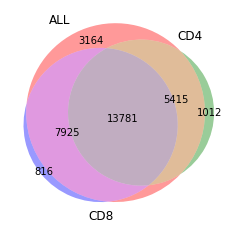

In [11]:
from matplotlib import pyplot as plt
from matplotlib_venn import venn3

# Define the sets
set1 = set(all_SNPs_all[(all_SNPs_all["corrected_p_val_greater"] < 0.1) | (all_SNPs_all["corrected_p_val_less"] < 0.1)]["ID"].to_list())
set2 = set(all_SNPs_CD4_all[(all_SNPs_CD4_all["corrected_p_val_greater"] < 0.1) | (all_SNPs_CD4_all["corrected_p_val_less"] < 0.1)]["ID"].to_list())
set3 = set(all_SNPs_CD8_all[(all_SNPs_CD8_all["corrected_p_val_greater"] < 0.1) | (all_SNPs_CD8_all["corrected_p_val_less"] < 0.1)]["ID"].to_list())

fig, ax = plt.subplots(1,1,figsize=(4,4))
# Create the Venn diagram
v = venn3([set1, set2, set3], set_labels=('ALL', 'CD4', 'CD8'), ax=ax)

# Show the plot
fig.savefig(f"{base_dir}/ATAC_allelic_imbalance/figures/SNPs_allele_specific_overlaps.svg", dpi = 600)